In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70

base_dir = Path().resolve().parent
data_dir = base_dir / 'data'
sys.path.append(str(base_dir))

## Признаки и препроцессинг

In [2]:
data = pd.read_excel(data_dir / 'originalData.xlsx')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

features = ['Income', 'Outcome']  # Условные фичи
target = 'Balance'

train_threshold = int(data.shape[0] * 0.8)
data_train, data_test = data.iloc[:train_threshold], data.iloc[train_threshold:]
X, y = data[features], data[target]
X_train, y_train = data_train[features], data_train[target]
X_test, y_test = data_test[features], data_test[target]

## Модель

 а так же отбор признаков
 и перебор гиперпараметров

Пайплайн при фиксированной выборке:

In [3]:
from sklearn.svm import SVR
from tslib.calibrate import calibrate_model
from tslib.scoring import get_score

params = {'C': [0.1, 0.5, 1, 5, 10],
          'kernel': ['rbf', 'linear', 'poly'],
          'gamma': ['auto', 'scale']}

# Еще добавить отбор признаков

model = calibrate_model(SVR, params, X_train, y_train)

pred = model.predict(X_test)
get_score(y_test, pred)

0.5676329873807074

## Симуляция с дообучением и калибровкой

In [24]:
period_retrain_calibrate = 'M'

base_sample_size = 500  # Начальный объём выборки
sample_size = data.shape[0]

Вызывается трекер разладки:

In [25]:
import tslib.cusum_finder as cusum_finder

var = 1.
alpha = 0.05
beta = 0.005

# Рассматриваем разладки убывающие
mean_diff = -0.01

stat_trajectory = []
mean_values = []

cusum = cusum_finder.CusumFinder(alpha, beta, mean_diff, 
                              trsh=0.03, slice_length=5, breaks_max=3)

# Начальный расчёт метрики для разладки на обучающей выборке
stat_trajectory = []
for y_k in y_train.values[:base_sample_size]:
    cusum.update(y_k)
    cusum.count_metric()
    stat_trajectory.append(cusum.metric)

# Счётчик разладки
breakpoint = False

In [26]:
model = calibrate_model(SVR, params, X_train, y_train)

metrics = []

for new_sample_size in tqdm(range(base_sample_size, sample_size)):

    current_data_train = data.iloc[:new_sample_size]
    current_data_test = data.iloc[new_sample_size:new_sample_size+1]

    X_train, y_train = current_data_train[features], current_data_train[target]
    
    # Если разладка происходит больше 10 дней из 15 предыдущих, то бьём тревогу
    if np.sum(np.array(cusum.breakpoints[-15:]) == 'red') >= 10:
        model = calibrate_model(SVR, params, X_train, y_train)
        breakpoint = True
    else:
        breakpoint = False
        
    X_test, y_test = current_data_test[features], current_data_test[target]

    if period_retrain_calibrate == 'M' and breakpoint == False:
        if X_test.index[0].day == 1:
            model = calibrate_model(SVR, params, X_train, y_train)
#     else:
#         raise NotImplementedError

    pred = model.predict(X_test)
    metrics.append(get_score(y_test, pred))
    
    # Обновляем статистику
    cusum.update(y_test.values[0])
    cusum.count_metric()
    stat_trajectory.append(cusum.metric)

  0%|          | 0/1043 [00:00<?, ?it/s]

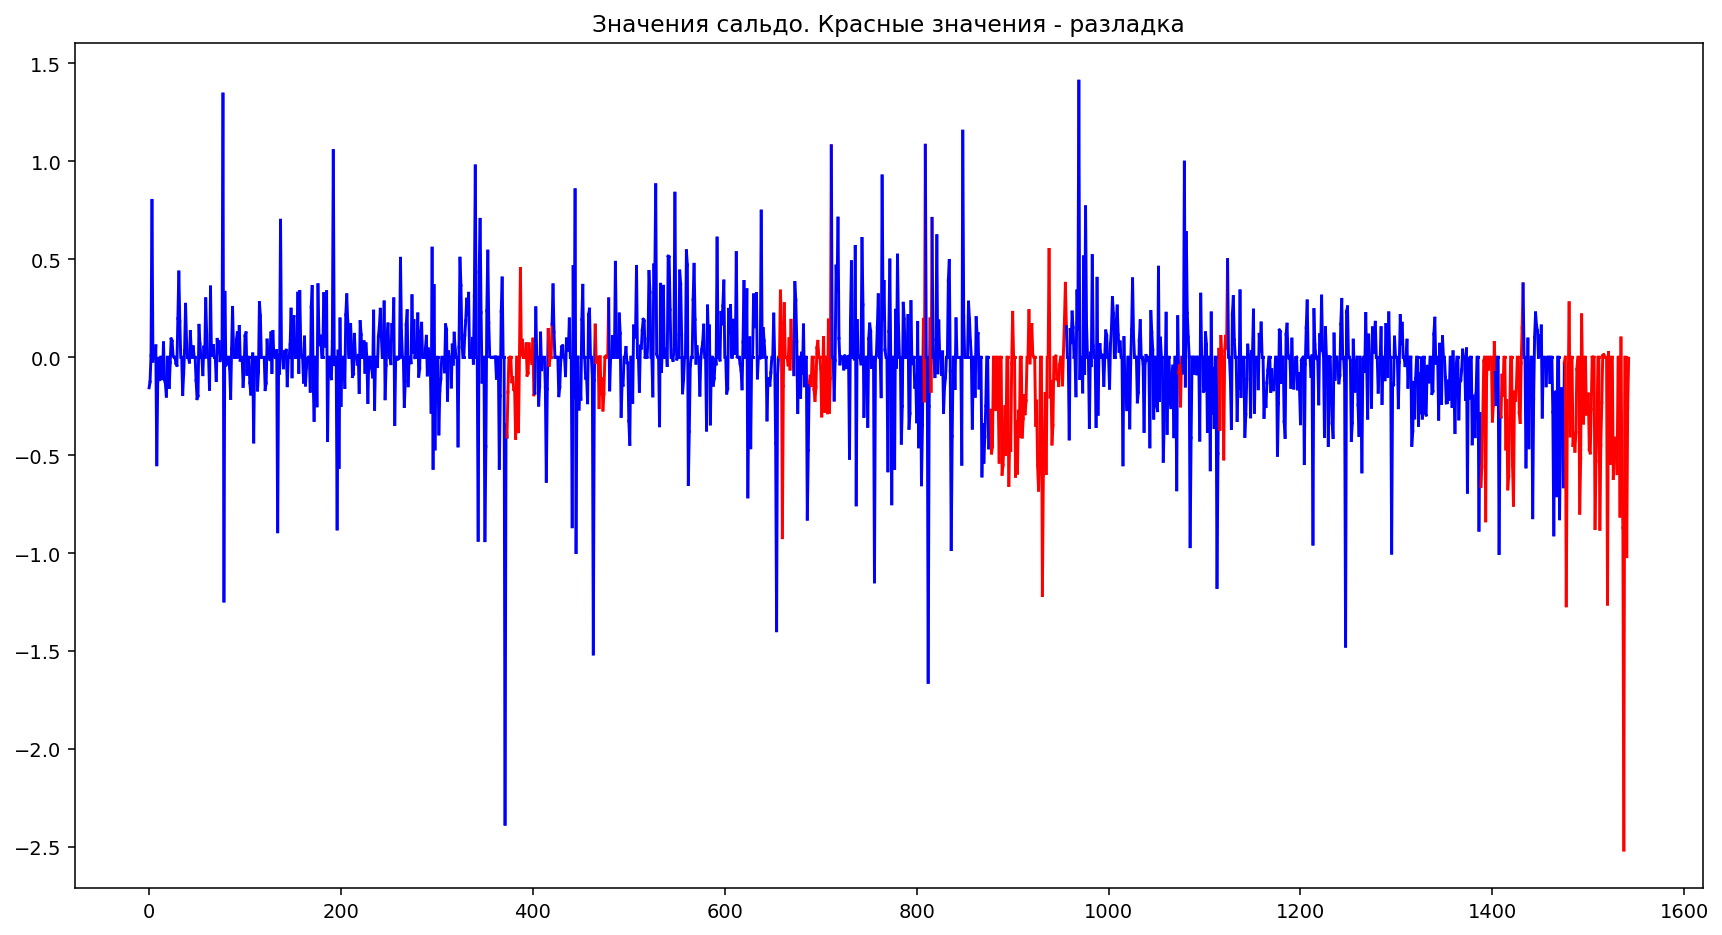

In [27]:
fig, ax = plt.subplots(figsize=(15,8))

for i in range(1, len(data['Balance'].values)):
    
    x = [i-1, i]
    y = [data['Balance'].values[i-1], data['Balance'].values[i]]
    
    ax.plot(x, y, color=cusum.breakpoints[i])
    
plt.title('Значения сальдо. Красные значения - разладка')
plt.show()

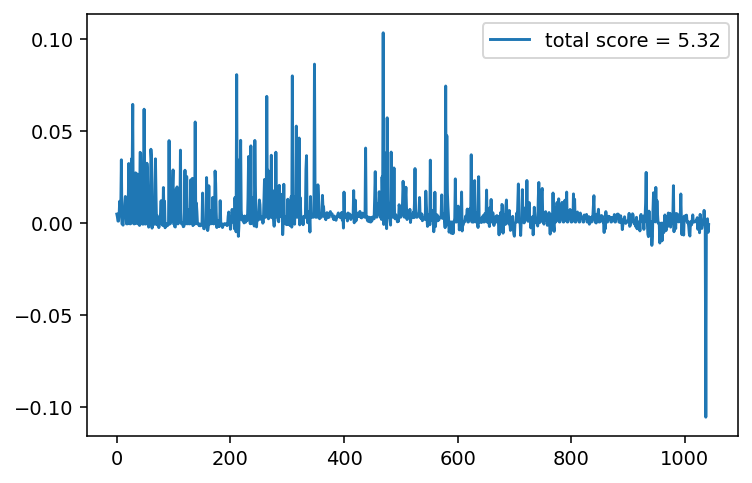

In [28]:
plt.plot(metrics, label=f'total score = {sum(metrics):.2f}')
plt.legend();